In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
from config import RANDOM_SEED

# download again originals csv to iterate on attack_cat column
train_path = '../data/UNSW_NB15_training-set.csv'     
test_path = '../data/UNSW_NB15_testing-set.csv'     
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# fill out null types in attack_types to normal
df_train['attack_cat'] = df_train['attack_cat'].fillna('Normal').str.strip()
df_test['attack_cat'] = df_test['attack_cat'].fillna('Normal').str.strip()

# names correction
mapping = {'Backdoors': 'Backdoor', 'Fuzzers': 'Fuzzers', 'Shellcode': 'Shellcode'} 
df_train['attack_cat'] = df_train['attack_cat'].replace(mapping)
df_test['attack_cat'] = df_test['attack_cat'].replace(mapping)

le_target = LabelEncoder()
all_cats = pd.concat([df_train['attack_cat'], df_test['attack_cat']]).unique()
le_target.fit(all_cats)

y_train_multi = le_target.transform(df_train['attack_cat'])
y_test_multi = le_target.transform(df_test['attack_cat'])

print("Classes:", le_target.classes_)

X_train = joblib.load('../processed/X_train_scaled.pkl')
X_test = joblib.load('../processed/X_test_scaled.pkl')

Classes: ['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# multiClass configuration
xgb_multi = XGBClassifier(
    n_estimators=26,           
    max_depth=4,               
    min_child_weight=5,     
    subsample=0.8,            
    colsample_bytree=0.1,   
    scale_pos_weight=4,      
    random_state=RANDOM_SEED,
    num_class=len(le_target.classes_),
    n_jobs=-1
)

#multi-class training
xgb_multi.fit(X_train, y_train_multi)

#predictions
y_pred_multi = xgb_multi.predict(X_test)

# target_names write real names (DoS, Normal, etc.) instead of numbers
print(classification_report(y_test_multi, y_pred_multi, target_names=le_target.classes_))

c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:26:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.75      0.01      0.01       583
           DoS       0.15      0.06      0.08      4089
      Exploits       0.54      0.80      0.64     11132
       Fuzzers       0.19      0.40      0.26      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.83      0.67      0.74     37000
Reconnaissance       0.77      0.71      0.74      3496
     Shellcode       0.47      0.06      0.10       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.69     82332
     macro avg       0.47      0.37      0.35     82332
  weighted avg       0.74      0.69      0.70     82332



c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [4]:
from sklearn.utils.class_weight import compute_class_weight

# Calculating weights to archive small classes to get more importance 
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_multi),
    y=y_train_multi
)
weights_dict = dict(zip(np.unique(y_train_multi), weights))

# add weights for each traininf set feature 
sample_weights = np.array([weights_dict[cls] for cls in y_train_multi])

xgb_multi_balanced = XGBClassifier(
    n_estimators=26,           
    max_depth=4,               
    min_child_weight=5,     
    subsample=0.8,            
    colsample_bytree=0.1,   
    scale_pos_weight=4,      
    random_state=RANDOM_SEED,
    num_class=len(le_target.classes_),
    n_jobs=-1
)
#training the model
xgb_multi_balanced.fit(X_train, y_train_multi, sample_weight=sample_weights)

y_pred_bal = xgb_multi_balanced.predict(X_test)
print(classification_report(y_test_multi, y_pred_bal, target_names=le_target.classes_))
#less global accuracy but diagnostic capacity

c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:26:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                precision    recall  f1-score   support

      Analysis       0.02      0.06      0.03       677
      Backdoor       0.04      0.41      0.07       583
           DoS       0.18      0.10      0.13      4089
      Exploits       0.85      0.46      0.59     11132
       Fuzzers       0.21      0.44      0.29      6062
       Generic       1.00      0.96      0.98     18871
        Normal       0.86      0.64      0.73     37000
Reconnaissance       0.81      0.78      0.79      3496
     Shellcode       0.11      0.75      0.19       378
         Worms       0.04      0.86      0.08        44

      accuracy                           0.65     82332
     macro avg       0.41      0.55      0.39     82332
  weighted avg       0.79      0.65      0.70     82332



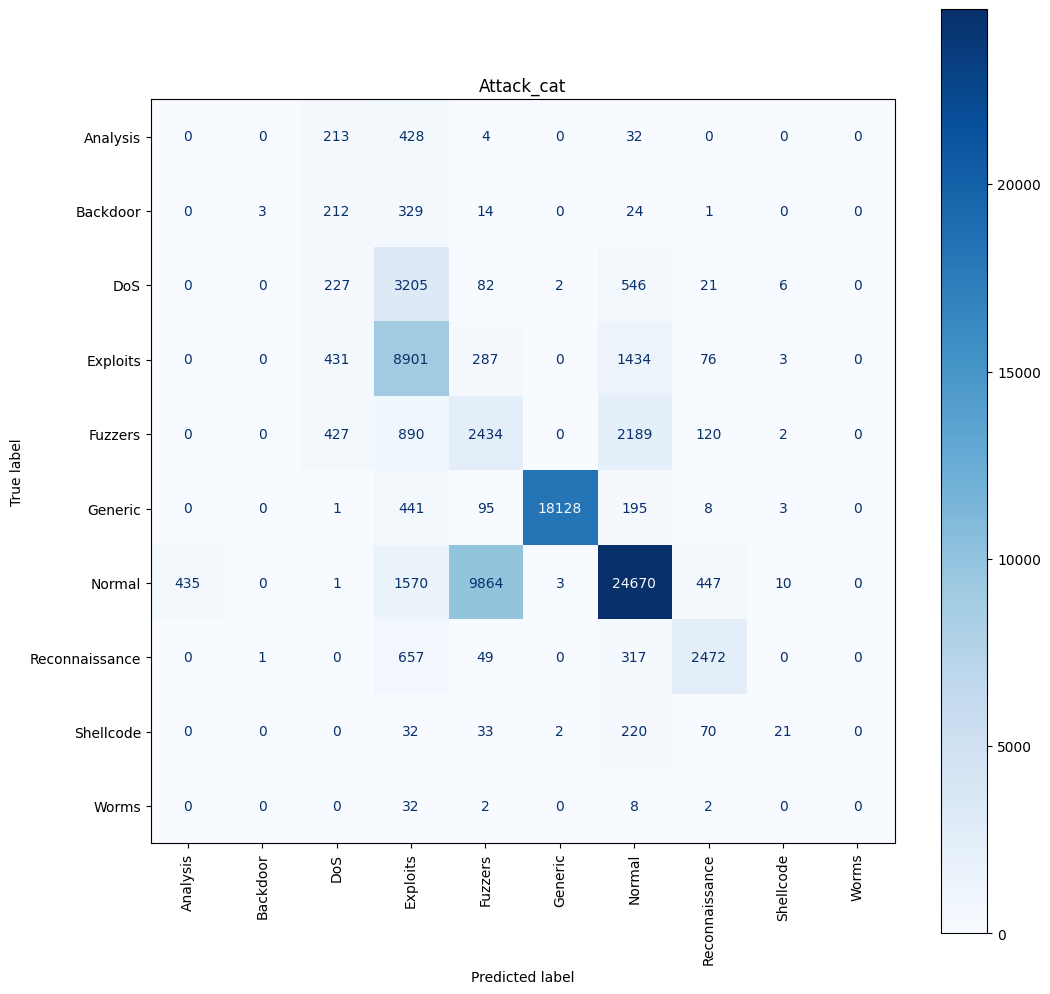

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_multi, 
    y_pred_multi,
    display_labels=le_target.classes_,
    cmap='Blues',
    xticks_rotation='vertical',
    ax=ax,
    values_format='d'
)
plt.title("Attack_cat")
plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_8232\1360609328.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


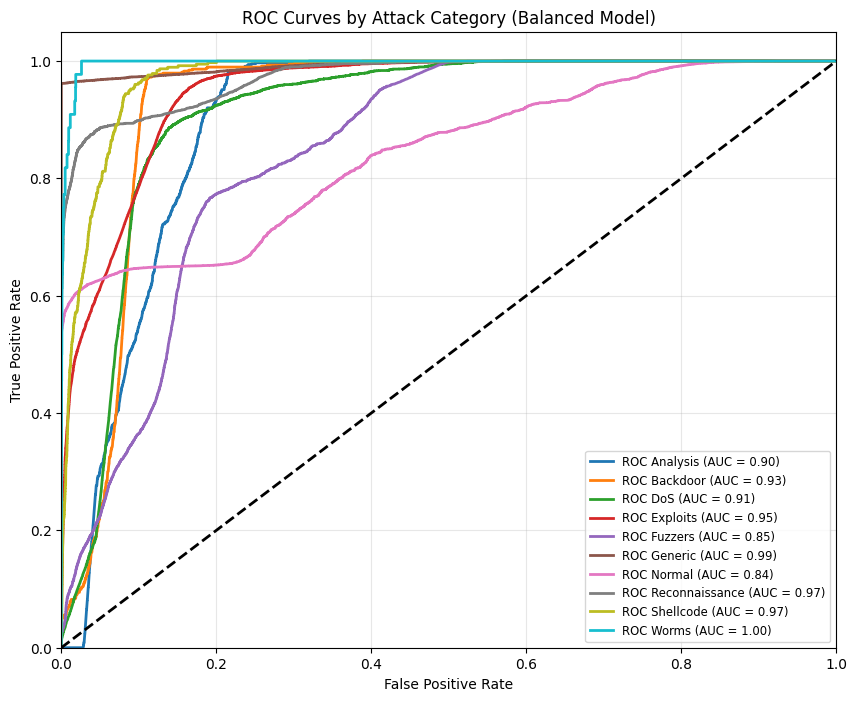

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# binarize labels to calculing multi-class 
classes = list(le_target.classes_)
n_classes = len(classes)
y_test_bin = label_binarize(y_test_multi, classes=range(n_classes))

# balance model 
y_score = xgb_multi_balanced.predict_proba(X_test)

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors(i), lw=2,
             label=f'ROC {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Attack Category (Balanced Model)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(alpha=0.3)
plt.show()

Iniciando análisis de escalabilidad (estratificado)...


c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:06:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Dataset al 10%: Tiempo = 0.39s, F1 = 0.7010


c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:06:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Dataset al 30%: Tiempo = 0.92s, F1 = 0.7009


c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:06:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Dataset al 50%: Tiempo = 1.30s, F1 = 0.6978


c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Dataset al 70%: Tiempo = 2.50s, F1 = 0.6981


c:\Users\danie\OneDrive\Imágenes\Escritorio\IA\project\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:06:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Dataset al 99%: Tiempo = 4.94s, F1 = 0.6957


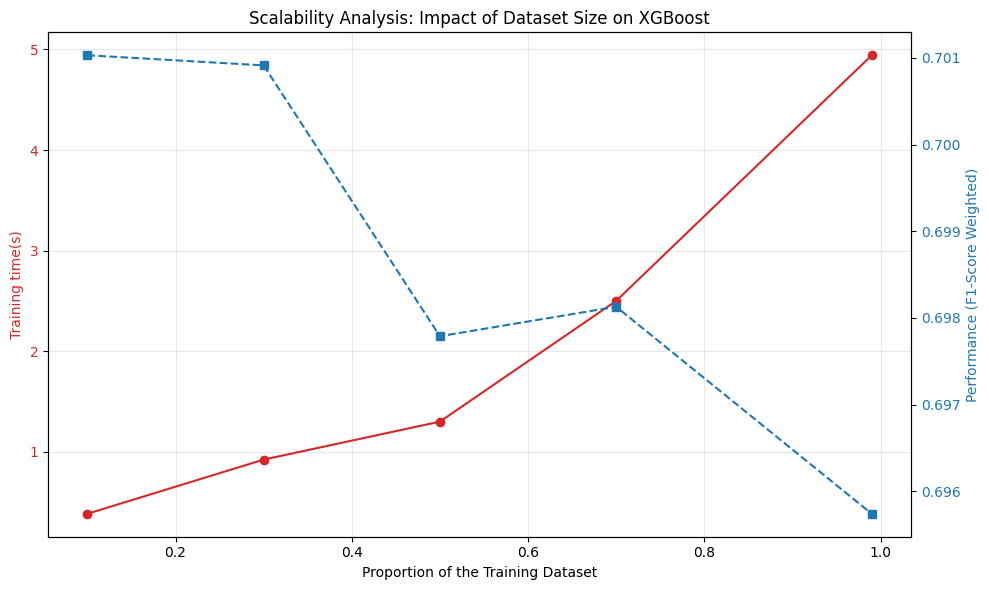

In [17]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def plot_scalability_fixed(model_class, X_train, y_train, X_test, y_test, le_classes):
    # Sizes: 10%, 30%, 50%, 70%, 100%
    sizes = [0.1, 0.3, 0.5, 0.7, 0.99] 
    times = []
    f1_scores = []
    
    print("Iniciando análisis de escalabilidad (estratificado)...")
    
    for size in sizes:
        # using train_test_split with stratify to ensure that every class are in the subset 
        if size < 1.0:
            X_sub, _, y_sub, _ = train_test_split(
                X_train, y_train, train_size=size, stratify=y_train, random_state=42
            )
        else:
            X_sub, y_sub = X_train, y_train
            
        # Calcualte again weights for the actual subset 
        unique_classes = np.unique(y_sub)
        current_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=y_sub
        )
        weights_dict = dict(zip(unique_classes, current_weights))
        sub_sample_weights = np.array([weights_dict[cls] for cls in y_sub])
        
        # measure time
        start = time.time()
        xgb_multi_balanced.fit(X_sub, y_sub, sample_weight=sub_sample_weights)
        elapsed = time.time() - start
        times.append(elapsed)
        
        # measure performance
        preds = xgb_multi_balanced.predict(X_test)
        score = f1_score(y_test, preds, average='weighted')
        f1_scores.append(score)
        
        print(f"Dataset al {int(size*100)}%: Tiempo = {elapsed:.2f}s, F1 = {score:.4f}")

    fig, ax1 = plt.subplots(figsize=(10,6))
    
    ax1.set_xlabel('Proportion of the Training Dataset')
    ax1.set_ylabel('Training time(s)', color='tab:red')
    ax1.plot(sizes, times, 'o-', color='tab:red', label='Tiempo de CPU')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Performance (F1-Score Weighted)', color='tab:blue')
    ax2.plot(sizes, f1_scores, 's--', color='tab:blue', label='F1-Score')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Scalability Analysis: Impact of Dataset Size on XGBoost')
    fig.tight_layout()
    plt.show()


plot_scalability_fixed(XGBClassifier, X_train, y_train_multi, X_test, y_test_multi, le_target.classes_)

In [18]:
import joblib
joblib.dump(xgb_multi_balanced, '../processed/final_multi_class_model.pkl')
joblib.dump(le_target, '../processed/target_encoder.pkl')

['../processed/target_encoder.pkl']